![logo](../../picture/license_header_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). <br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# Multivariate Input, Univariate Output LSTM, Single Step

## Introduction
This tutorial is to demonstrate the process to build LSTM for the Multivariate Input, Univariate Output LSTM, Single Step<br>

It consists of 2 major parts which are :<br>

Part 1 - The Demonstration of Building LSTM using Synthetic data<br>
Part 2 - Exercise of building LSTM using COVID-19 Data.<br>


## What will we accomplish?
First, we will show the step in building the LSTM :

Step 1. Data Preparation (Data Splitting, Data Sequencing, Data Standardization and Batching the Data)<br>
Step 2. Model Configuration (Vanilla LSTM, Stacked LSTM, Bidirectional LSTM)<br>
Step 3. Train the model<br>
Step 4. Validate the model using a graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>

Secondly, learn to import the function from module `data_module.py` and `deep_learning_module.py`<br>

Thirdly, some data exploration technique on COVID-19 data

Let's import the package needed

In [1]:
# import libary need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module

# Part 1 : Demonstration of Building LSTM using Synthetic data

## Hyperparameter
Define the hyperparameter that needs to be tuned.

In [2]:
split_ratio = 0.70
num_epochs = 300
window_size = 4
n_step = 1
learning_rate = 0.01
batch_size = 10


# Step 1 : Data Preparation
We create synthetic data to make sure the model is created correctly and having the ability to perform the forecasting. <br>

1. First, we will create a sequence of data with `np.array`.
2. Then, we will assign a date to the sequence of data with `pd.date_range` and store it to series data by using `pd.Series`.


In [3]:
#Synthetic Data
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [4]:
dataset = pd.DataFrame(dataset,columns =["in_seq1","in_seq2","out_seq"],
                      index = pd.date_range("1/1/2020",periods=len(dataset),freq='D'))
dataset.index.name="Date"
dataset.head()

,in_seq1,in_seq2,out_seq
Date,,,
2020-01-01,0,5,5
2020-01-02,10,15,25
2020-01-03,20,25,45
2020-01-04,30,35,65
2020-01-05,40,45,85


## Data Visualization
Data visualization is important for us to visualize the pattern of data such as trend and seasonality. As seen in the graph below, there is an increasing trend in the data.

Text(0.5, 1.0, 'Synthetic Data')

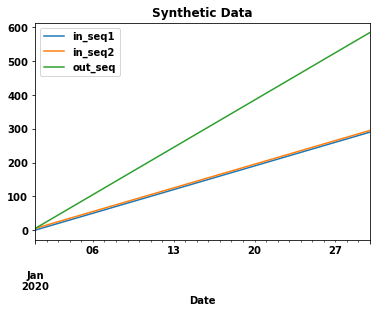

In [5]:
dataset.plot()
plt.title("Synthetic Data")

## Data Splitting
In Deep Learning, we will split the data into training and test dataset. The training data is used to train the model whereas the test data is used to validate the performance of the model.

In [6]:
split_data = round(len(dataset)*split_ratio)
split_data

21

In [7]:
#split data by indexing 
train_data = dataset[:split_data]
test_data = dataset[split_data:]
train_time = dataset.index[:split_data]
test_time = dataset.index[split_data:]

print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


In [8]:
len(train_data['in_seq1'])

21

## Data Standardization
Standardize the data based on every column to have 0 mean and unit variance to make our model converge faster. 

In [9]:
def multi_data_scaler(train_data,test_data,scale_mode = "Standardize"):   
    """ 
    Perform Data Scalling 
    
    Arguments:
    train_data: Train Data
    test_data: Test Data
    scale_mode: Types of scaler ["Normalize": MinMaxScaler(),"Standardize": StandardScaler()]
    
    Returns: 
    scaler, scaled train data. scaled test data
    """
    scalers = dict()
    data_dict = {"train_data":train_data,
                "test_data":test_data}
    
    scale_type ={"Normalize": MinMaxScaler(),
                "Standardize": StandardScaler()}
    
    if scale_mode not in scale_type:
        print("Invalid scale mode. Expected one of: %s" %scale_type.keys())
    
    for columns in train_data.columns:
        scaler= scale_type[scale_mode].fit(train_data[columns].values.reshape(-1,1))
        scalers['scaler+'+columns] = scaler
        
    for key in data_dict:
        data_scaled = list()
        for columns in data_dict[key].columns:
            data_scaled.append(scaler.transform(data_dict[key][columns].values.reshape(-1,1)))
        standard_data = np.array(data_scaled)
        data_dict[key] = np.transpose(np.squeeze(standard_data))
        
    return scalers,data_dict["train_data"],data_dict["test_data"]

In [10]:
data_scalers,train_data_standard, test_data_standard = multi_data_scaler(train_data,test_data)
print("train_data_standardized"+str(train_data_standard.shape))
print("test_data_standardized"+str(test_data_standard.shape))

train_data_standardized(21, 3)
test_data_standardized(9, 3)


## Data Sequencing
Sequencing the data by taking in the multivariate series into `feature` and `label`
<img src = "../../picture/Multivariate Data Sequencing.png"  width="300" height  ="300" align="center" />

In [11]:

trainX ,trainY = data_module.multivariate_univariate_single_step(train_data_standard,window_size)
testX , testY = data_module.multivariate_univariate_single_step(test_data_standard,window_size)


print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(18, 4, 2) trainY shape:(18,)

testX shape:(6, 4, 2) testY shape:(6,)


In [12]:
trainY = trainY.reshape(trainY.shape[0],1,n_step)
testY = testY.reshape(testY.shape[0],1,n_step)
print(f"trainY shape:{trainY.shape}")
print(f"testY shape:{testY.shape}")

trainY shape:(18, 1, 1)
testY shape:(6, 1, 1)


## Data Transformation
Data needs to be transformed from NumPy to PyTorch tensor before being fed into the model. The input of an LSTM model has to be 3-dimensional.

>**Instruction** : <br>
Use `data_module.key_assign` to assign the key and `data_module.transform` to transform the data.

In [13]:

train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)
train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)


In [14]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([18, 4, 2])
train_data_y_label shape : torch.Size([18, 1, 1])
test_data_x_feature shape : torch.Size([6, 4, 2])
test_data_y_label shape : torch.Size([6, 1, 1])


## Data Iterator
Iterator is created to separate the data into several batches to fasten the training process.
>**Instruction** : <br>
Use `data_module.iterator` to create data iterator.

In [15]:
train_iter , test_iter = data_module.iterator(train_data_dict ,test_data_dict,batch_size = batch_size)

# Step 2 : LSTM Model Configuration 
Please refer to [04 - LSTM_Univariate_SingleStep # Step 2 : LSTM Model Configuration ](./04%20-%20LSTM_Univariate_SingleStep.ipynb) for the explanation

## Input Model
The model is initiated with the following required attributes: **number of input layer**, **output layer** and **hidden layer**.

How to Use : 

1. Select one of the model base on the application as below and comment out other models
2. IF use Vanilla LSTM, set num_layer = 1 and use `model = LSTM()`
3. IF use stacked LSTM, set num_layer more than 1 and use `model = LSTM()`
4. IF use Bidirectional LSTM, use  `model = BidirectionalLSTM()`

>**Instruction** : <br>
Import the LSTM model from `deep_learning_module`. You are required to import both Vanilla LSTM and Bidirectional LSTM and save it as `model` <br>

*Feel free to comment out one of the model to use it*

In [16]:
#seed
torch.manual_seed(123)

#Arguments for LSTM model
hidden_dim = 32
number_of_time_series = trainX.shape[2] 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1

#Vanila , Stacked LSTM
model = deep_learning_module.LSTM(n_feature = number_of_time_series, 
                                  hidden_dim = hidden_dim ,
                                  num_layers = num_layers , 
                                  n_step = n_step )

#Bidirectional LSTM
# model = deep_learning_module.BidirectionalLSTM(n_feature = number_of_time_series, 
#                                                hidden_dim = hidden_dim ,
#                                                num_layers = num_layers , 
#                                                n_step = n_step)

In [17]:
# print the summary of the LSTM model
inputs = torch.zeros((batch_size,window_size,trainX.shape[2]),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs))

       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -  [10, 4, 32]    4608       4352
1_fc        [32, 1]      [10, 1]      33         32
---------------------------------------------------
                      Totals
Total params            4641
Trainable params        4641
Non-trainable params       0
Mult-Adds               4384
       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -  [10, 4, 32]    4608       4352
1_fc        [32, 1]      [10, 1]      33         32


Define the MSE as loss function and use Adam as the model optimizer

In [18]:
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Step 3 : Training
>**Instruction** : <br>
Use `deep_learning_module.training` to train the model.


In [19]:
#seed
torch.manual_seed(123)

# Start Training
train_loss,val_loss = deep_learning_module.training(num_epochs= num_epochs ,
                                                    train_iter = train_iter,
                                                    test_iter = test_iter ,
                                                    optimizer = optimizer,
                                                    loss_fn = loss_fn,
                                                    model = model)

# Step 4 : Validation
A train loss and val loss is plotted to define how well the data is fits into the model

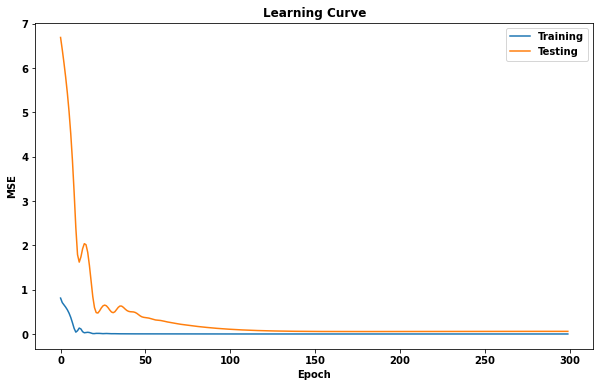

Epoch : 0 , training loss : 0.8100464476479424 , validation loss : 6.693227767944336
Epoch : 1 , training loss : 0.7088292506006029 , validation loss : 6.419505596160889
Epoch : 2 , training loss : 0.657656643125746 , validation loss : 6.121475696563721
Epoch : 3 , training loss : 0.605959008137385 , validation loss : 5.799461364746094
Epoch : 4 , training loss : 0.5458055635293325 , validation loss : 5.4394049644470215
Epoch : 5 , training loss : 0.4706747565004561 , validation loss : 5.021522045135498
Epoch : 6 , training loss : 0.37424466013908386 , validation loss : 4.522329330444336
Epoch : 7 , training loss : 0.25449493444628185 , validation loss : 3.917255401611328
Epoch : 8 , training loss : 0.12597354563573995 , validation loss : 3.193571090698242
Epoch : 9 , training loss : 0.04140631096541054 , validation loss : 2.397308826446533
Epoch : 10 , training loss : 0.07393988346060117 , validation loss : 1.7903872728347778
Epoch : 11 , training loss : 0.13353021608458626 , validati

In [20]:
data_module.learning_curve(num_epochs = num_epochs,
                           train_loss = train_loss ,
                           val_loss = val_loss)
                           

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data, determining the output forecast value and calculating the RMSE. For this tutorial, we will use the function in `data_module` to run in each section.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

In [21]:
# Section 1 : make predictions
y_train_prediction = model(train_data_dict['train_data_x_feature'])
y_test_prediction = model(test_data_dict['test_data_x_feature'])


In [22]:
# Assign evaluation key
prediction , output = data_module.key_assign_evaluation(y_train_prediction,
    y_test_prediction,
    train_data_dict,
    test_data_dict)
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)

In [23]:
data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([18, 1])
test_data_output shape : torch.Size([6, 1])


In [24]:
# Section 3 : Invert predictions
output_data_scaler = data_scalers[list(data_scalers)[-1]]
prediction = data_module.inverse_scaler(prediction,scaler = output_data_scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler = output_data_scaler)

In [25]:
data_module.sanity_check(data_1 = prediction,data_2 = output_data )

train_data_prediction shape : (18, 1)
test_data_prediction shape : (6, 1)
train_data_output shape : (18, 1)
test_data_output shape : (6, 1)


In [26]:
# List the forecast value
data_module.list_forecast_value(output_data,prediction) 

Test Data			Forecast
[485.]		[475.10242]
[505.]		[490.0065]
[525.]		[503.71637]
[545.]		[516.24225]
[565.]		[527.6221]
[585.]		[537.91284]


In [27]:
# Section 4 : Calculate the RMSE of train and test data
trainScore,testScore = data_module.rmse(prediction,output_data)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.01 RMSE
Test Score: 29.49 RMSE


# Step 6 : Forecast Plot

Referring to the data sequence diagram (Figure 2) for the multivariate input, univariate output, the red box indicates a sliding window that contains 3 data points (which meant that `window_size = 3` in this case). You can find that the last data point within the red box is at the same location (`time series 1 = 30`,`time series 2 = 35`,`output series 3 = 65`).<br>

If you are using the `single_step_plot` from `data_module` you can find that the time index for test data after sequence(window sliding) is using `test_time[window_size:]`. Due to Python's indexing properties, it will slide from the 4th position of the time index (the time index for `output series 3 = 85`).<br>

To make sure your time index for test data after data sequencing is correct, you need to modify the `single_step_plot` by adding in `test_time[window_size - 1:] `if `multivariate = True`

<img src = "../../picture/Data Sequencing in Univariate Single Step.png"   width="300" height  ="300" align="center" /><br>
#### <center>Figure 1 : Data sequence diagram for univariate single step</center>
<img src = "../../picture/Multivariate Data Sequencing.png"  width="300" height  ="300" align="center" /><br>
#### <center>Figure 2 : Data sequence diagram for multivariate input , univariate output</center>

As you can observe in below, the length for `test_time[window_size:] = 5` but `output_data['test_data_output']  = 6` and `prediction['test_data_prediction'].shape = 6`

In [28]:
print(f"Length of test time in single_step_plot function  = {len(test_time[window_size:])}")
print(f"Length of test_data_output = {len(output_data['test_data_output'])}")
print(f"Length of test_data_prediction  = {len(prediction['test_data_prediction'])}")
print(f"Length of test time for test_time[window_size-1] = {len(test_time[window_size-1:])}")

Length of test time in single_step_plot function  = 5
Length of test_data_output = 6
Length of test_data_prediction  = 6
Length of test time for test_time[window_size-1] = 6


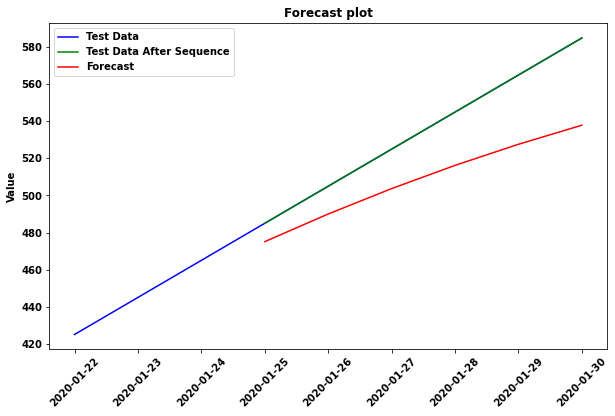

In [29]:
def single_step_plot(original_test_data,sequence_test_data,forecast_data,test_time,window_size,
                     original_plot =False,multivariate = False):
    sequence_test_time = test_time[window_size:]
    plt.figure(figsize=(10,6))
    
    if multivariate:
        sequence_test_time = test_time[window_size-1:]
                                 
    if original_plot:
        plt.plot(test_time,original_test_data,color="blue",label = 'Test Data')
        
    plt.plot(sequence_test_time,sequence_test_data,color="green", label = 'Test Data After Sequence')
    plt.plot(sequence_test_time,forecast_data,color="red", label = 'Forecast')
    plt.xticks(rotation = 45)
    plt.ylabel("Value")
    plt.title("Forecast plot")
    plt.legend()

single_step_plot(original_test_data = test_data["out_seq"],
                 sequence_test_data = output_data['test_data_output'],
                 forecast_data = prediction['test_data_prediction'],
                 test_time = test_time,
                 window_size = window_size,
                 original_plot = True,
                 multivariate = True)

# Part 2 : Exercise for Multivariate
## Task : Predict the total number of death cases in COVID-19 Malaysia 

### Introduction 
You are given a set of data that contains information about COVID-19 cases worldwide. You are required to perform some data analysis on it and predict the death cases.<br>

Please follow the instruction and try to code the exercise.Please feel free to google to find out how to use a particular function in the data exploration part<br>



Data Source : 
https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset



## Hyperparameter
>**Instruction** : <br>
You are required to fill `None` with a suitable value to make the model converge

>**Expected Result** : <br>
Train Score <= 10 RMSE<br>
Test Score <= 10 RMSE<br>

In [30]:
#Hyperameter
split_ratio_covid = 0.70
num_epochs_covid = 100
window_size_covid = 10
n_step_covid = 1
learning_rate_covid = 0.001
batch_size_covid = 20
#seed
torch.manual_seed(123)

# Step 1 : Data Preparation
In this tutorial, you will face a complex real-world dataset. You are required to use some of the data exploration technique to help you prepare the data.

>**Instruction** : <br>
Read the file using `pd.read_csv`<br>
Save your data as `cases`<br>
Your file path `../../datasets/others/covid_19_data.csv`

In [31]:
### BEGIN SOLUTION
cases = pd.read_csv("../../datasets/others/covid_19_data.csv")
### END SOLUTION
cases.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


As you can see, the data contains info on COVID-19 cases from other countries as well. You will need to slice the COVID-19 info for Malaysia.

>**Instruction** : <br>
Slice the COVID-19 info for Malaysia. You might need to use `df.loc[]` to help you slice the data.

>**Expected Result** :<br>
Example of first 5 rows of data:

---	|SNo	|ObservationDate	|Province/State	|Country/Region	|Last Update	|Confirmed	|Deaths	|Recovered
 ---|---	|---	            |---	        |---	        |---	        |---	    |---	|---
78	|79	    |01/23/2020	|NaN	|Malaysia	|1/23/20 |17:00	|0.0	|0.0	|0.0
168	|169	|01/25/2020	|NaN	|Malaysia	|1/25/20 |17:00	|3.0	|0.0	|0.0
214	|215	|01/26/2020	|NaN	|Malaysia	|1/26/20 |16:00	|4.0	|0.0	|0.0
260	|261	|01/27/2020	|NaN	|Malaysia	|1/27/20 |23:59	|4.0	|0.0	|0.0
311	|312	|01/28/2020	|NaN	|Malaysia	|1/28/20 |23:00	|4.0	|0.0	|0.0


In [32]:
cases["Country/Region"].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

In [33]:
### BEGIN SOLUTION
new_covid_data = cases.loc[cases["Country/Region"] == 'Malaysia']
new_covid_data.head()
### END SOLUTION

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
78,79,01/23/2020,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
168,169,01/25/2020,NaN,Malaysia,1/25/20 17:00,3.0,0.0,0.0
214,215,01/26/2020,NaN,Malaysia,1/26/20 16:00,4.0,0.0,0.0
260,261,01/27/2020,NaN,Malaysia,1/27/20 23:59,4.0,0.0,0.0
311,312,01/28/2020,NaN,Malaysia,1/28/20 23:00,4.0,0.0,0.0


We need to make sure there is no missing value in our data
>**Instruction** : <br>
Use `df.isnull().values.any()` to check any missing data in our dataset. `True` would imply that there is a `NaN` value in our dataset<br>
Most of the columns does not contain `NaN` except for `Province/State `. This is acceptable since this data is not really useful for our use case which we will drop later.

Columns|Status
---|---
SNo                |False
ObservationDate    |False
Province/State      |True
Country/Region     |False
Last Update        |False
Confirmed          |False
Deaths             |False
Recovered          |False

In [34]:
### BEGIN SOLUTION
new_covid_data.isnull().any()
### END SOLUTION

SNo                False
ObservationDate    False
Province/State      True
Country/Region     False
Last Update        False
Confirmed          False
Deaths             False
Recovered          False
dtype: bool

>**Instruction** : <br>
Set the `ObservationDate` as the index for the dataset. You are required to convert `ObservationDate` to datetime using `pd.to_datetime()` <br>

>**Expected Result** :<br>
Example of the first 5 rows of data:

ObservationDate	|SNo	|ObservationDate	|Province/State	|Country/Region	|Last Update	|Confirmed	|Deaths	|Recovered
 ---|---	|---	            |---	        |---	        |---	        |---	    |---	|---
01/23/2020	|79	    |01/23/2020	|NaN	|Malaysia	|1/23/20 |17:00	|0.0	|0.0	|0.0
01/25/2020	|169	|01/25/2020	|NaN	|Malaysia	|1/25/20 |17:00	|3.0	|0.0	|0.0
01/26/2020	|215	|01/26/2020	|NaN	|Malaysia	|1/26/20 |16:00	|4.0	|0.0	|0.0
01/27/2020	|261	|01/27/2020	|NaN	|Malaysia	|1/27/20 |23:59	|4.0	|0.0	|0.0
01/28/2020	|312	|01/28/2020	|NaN	|Malaysia	|1/28/20 |23:00	|4.0	|0.0	|0.0

In [35]:
### BEGIN SOLUTION
new_covid_data = new_covid_data.set_index(pd.to_datetime(new_covid_data["ObservationDate"]))
### END SOLUTION

new_covid_data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,,
2020-01-23,79,01/23/2020,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
2020-01-25,169,01/25/2020,NaN,Malaysia,1/25/20 17:00,3.0,0.0,0.0
2020-01-26,215,01/26/2020,NaN,Malaysia,1/26/20 16:00,4.0,0.0,0.0
2020-01-27,261,01/27/2020,NaN,Malaysia,1/27/20 23:59,4.0,0.0,0.0
2020-01-28,312,01/28/2020,NaN,Malaysia,1/28/20 23:00,4.0,0.0,0.0


Columns such as `SNo`,`ObservationDate`,`Province/State`,`Country/Region`,`Last Update` does not provide any useful information to us. Hence we need to drop it to make the data look cleaner. 

>**Instruction** : <br>
Use `df.drop` to drop the `columns = ['SNo','ObservationDate','Province/State','Country/Region','Last Update']`<br>

>**Expected Result** :<br>

ObservationDate	|Confirmed	|Deaths	|Recovered
	---|---|---|---		
2020-01-23|	0.0|	0.0|	0.0
2020-01-25|	3.0|	0.0|	0.0
2020-01-26|	4.0|	0.0|	0.0
2020-01-27|	4.0|	0.0|	0.0
2020-01-28|	4.0|    0.0|	0.0

In [36]:
### BEGIN SOLUTION
new_covid_data = new_covid_data.drop(columns = ['SNo','ObservationDate','Province/State','Country/Region','Last Update'])
### END SOLUTION
new_covid_data.head()


,Confirmed,Deaths,Recovered
ObservationDate,,,
2020-01-23,0.0,0.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,4.0,0.0,0.0
2020-01-27,4.0,0.0,0.0
2020-01-28,4.0,0.0,0.0


To make the sliding window function to work, you need to rearrange the data columns such a way that the targeted forecast series will be the last column of the data.
>**Instruction** : <br>
Rearrage the data column using `df[]`<br>
For example : <br>
columns = [`A`,`B`,`C`]<br>
rearrage columns = [`A`,`C`,`B`]<br>
`df =  df[rearrage columns]`

>**Expected Result** :<br>

ObservationDate|	Confirmed|	Recovered|	Deaths
		---|---|---|---	
2020-01-23|	0.0|	0.0|	0.0
2020-01-25|	3.0|	0.0|	0.0
2020-01-26|	4.0|	0.0|	0.0
2020-01-27|	4.0|	0.0|	0.0
2020-01-28|	4.0|	0.0|	0.0

In [37]:
### BEGIN SOLUTION
new_covid_data = new_covid_data[["Confirmed","Recovered","Deaths"]]
### END SOLUTION
new_covid_data.head()

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-23,0.0,0.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,4.0,0.0,0.0
2020-01-27,4.0,0.0,0.0
2020-01-28,4.0,0.0,0.0


## Data Visualization
Data visualization is vital for us to visualize the pattern of data such as trend and seasonality. The plot below shows that there is an increasing trend in data.

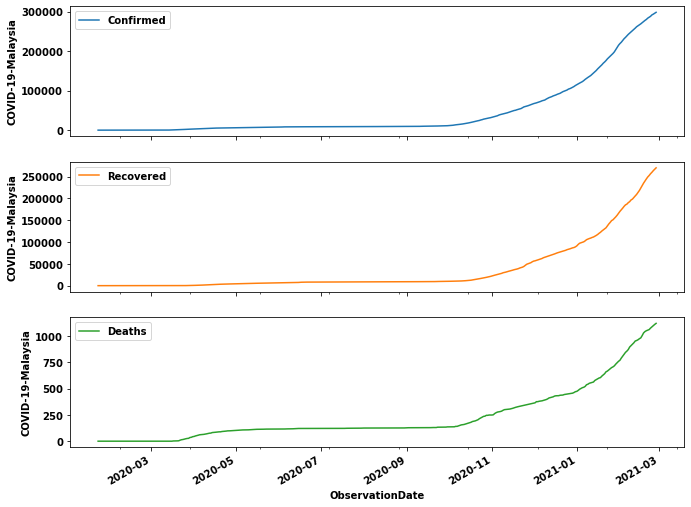

In [38]:
# Visualize Data 
axes = new_covid_data[new_covid_data.columns].plot(alpha=1.0, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('COVID-19-Malaysia')

However, the data is in a cumulative form. To perform time-series prediction, we need to convert the cumulative cases into daily cases.

>**Instruction** : <br>
Remove the cumulative counts. You might need to use a `For loop` to loop through the data for each columns. Use `new_covid_data[name] - new_covid_data[name].shift().fillna(0)` as the math operation to remove the cummulative<br>

>**Expected Result** :<br>

ObservationDate|	Confirmed|	Recovered|	Deaths|
	---|	---|---|---	
2020-01-23|	0.0|	0.0|	0.0|
2020-01-25|	3.0|	0.0|	0.0|
2020-01-26|	1.0|	0.0|	0.0|
2020-01-27|	0.0|	0.0|	0.0|
2020-01-28|	0.0|	0.0|	0.0|

In [39]:
### BEGIN SOLUTION
for name in new_covid_data.columns:
        new_covid_data[name] = new_covid_data[name] - new_covid_data[name].shift().fillna(0)
### END SOLUTION
new_covid_data.head()  

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-23,0.0,0.0,0.0
2020-01-25,3.0,0.0,0.0
2020-01-26,1.0,0.0,0.0
2020-01-27,0.0,0.0,0.0
2020-01-28,0.0,0.0,0.0


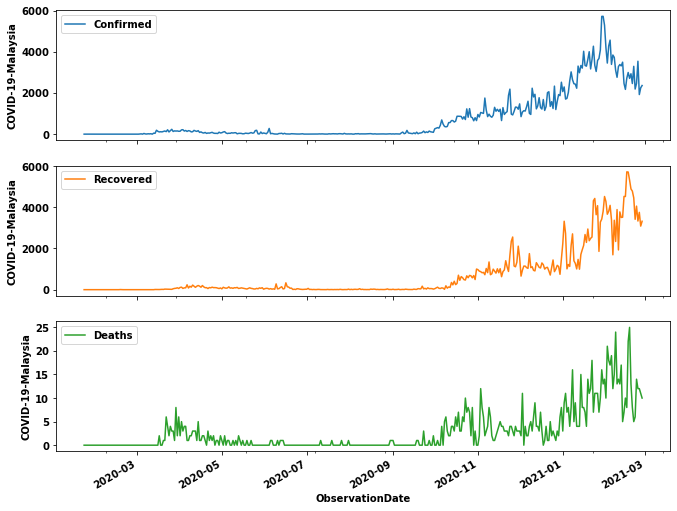

In [40]:
# Visualize Data 
axes = new_covid_data[new_covid_data.columns].plot(alpha=1.0, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('COVID-19-Malaysia')

## Data Splitting
In Deep Learning, we often split data into training and test dataset. The training data is used to train the model whereas the test data is used to validate the performance of the model.

In [41]:
split_data_covid = round(len(dataset)*split_ratio)
split_data_covid

21

In [42]:
# Split data by indexing 
train_data_covid = new_covid_data[:-split_data_covid ]
test_data_covid = new_covid_data[-split_data_covid :]
train_time_covid = new_covid_data.index[:-split_data_covid ]
test_time_covid = new_covid_data.index[-split_data_covid :]

print("train_data_shape")
print(train_data_covid.shape)
print("test_data_shape")
print(test_data_covid.shape)

train_data_shape
(380, 3)
test_data_shape
(21, 3)


## Data Normalization 
Normalize the data into range of 0 to 1

In [43]:
scaler_covid,train_data_normalized_covid,test_data_normalized_covid = multi_data_scaler(train_data_covid,
                                                                                         test_data_covid,
                                                                                         scale_mode = "Normalize")
print("train_data_normalized_demand"+str(train_data_normalized_covid.shape))
print("test_data_normalized_demand"+str(test_data_normalized_covid.shape))

train_data_normalized_demand(380, 3)
test_data_normalized_demand(21, 3)


## Data Sequencing
Sequencing the data by taking in the multivariate series into feature and label
<img src = "../../picture/Multivariate Data Sequencing.png"  width="300" height  ="300" align="center" />

In [44]:
trainX_covid ,trainY_covid=  data_module.multivariate_univariate_single_step(train_data_normalized_covid,window_size_covid)
testX_covid , testY_covid = data_module.multivariate_univariate_single_step(test_data_normalized_covid,window_size_covid)
print(f"trainX_demand shape:{trainX_covid.shape} trainY_demand shape:{trainY_covid.shape}\n")
print(f"testX_demand shape:{testX_covid.shape} testY_demand shape:{testY_covid.shape}")

trainX_demand shape:(371, 10, 2) trainY_demand shape:(371,)

testX_demand shape:(12, 10, 2) testY_demand shape:(12,)


In [45]:
trainY_covid = trainY_covid.reshape(trainY_covid.shape[0],1,n_step)
testY_covid = testY_covid.reshape(testY_covid.shape[0],1,n_step)
print(f"trainY shape:{trainY_covid.shape}")
print(f"testY shape:{testY_covid.shape}")

trainY shape:(371, 1, 1)
testY shape:(12, 1, 1)


### Data Transform
Data need to transformed from numpy to a 3D pytorch tensor before being fed into the LSTM model. 

>**Instruction** : <br>
Use `data_module.key_assign` to assign the key and `data_module.transform` to transform the data.

In [46]:
### BEGIN SOLUTION
train_data_dict_covid ,test_data_dict_covid = data_module.key_assign(trainingX = trainX_covid  , 
                       testingX = testX_covid, 
                       trainingY = trainY_covid, 
                       testingY = testY_covid)
train_data_dict_covid ,test_data_dict_covid = data_module.transform(train_data_dict_covid ,test_data_dict_covid)
### END SOLUTION

In [47]:
data_module.sanity_check(train_data_dict_covid , test_data_dict_covid)

train_data_x_feature shape : torch.Size([371, 10, 2])
train_data_y_label shape : torch.Size([371, 1, 1])
test_data_x_feature shape : torch.Size([12, 10, 2])
test_data_y_label shape : torch.Size([12, 1, 1])


## Data Iterator
Iterator is created to separate the data into several batches to fasten the training process.
>**Instruction** : <br>
Use `data_module.iterator` to create data iterator.

In [48]:
### BEGIN SOLUTION
train_iter_covid , test_iter_covid = data_module.iterator(train_data_dict_covid ,
                                                          test_data_dict_covid,
                                                          batch_size = batch_size_covid)
### END SOLUTION

## Input Model
The model is inputted with the following required attributes: number of input layer, output layer and hidden layer.

How to Use :

1. Select one of the model base on the application as below and comment others model
2. IF use Vanilla LSTM , set num_layer = 1 and use the model = LSTM()
3. IF use stacked LSTM , set num_layer more than 1 and use the model = LSTM()
4. IF use Bidirectional LSTM, use the model = BidirectionalLSTM()

>**Instruction** : <br>
Import the LSTM model from `deep_learning_module`.You are require to import both Vanilla LSTM and Bidirectional LSTM and save it as `model` <br>

*Feel free to comment out one of the model to use it*

In [49]:
#seed
torch.manual_seed(123)
### BEGIN SOLUTION
#Arguments for LSTM model
hidden_dim_covid = 32
n_feature_covid = trainX_covid.shape[2] 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers_covid = 1

n_step_covid = 1

#Vanilla , Stacked LSTM
model_covid = deep_learning_module.LSTM(n_feature = n_feature_covid, 
                                        hidden_dim = hidden_dim_covid ,
                                        num_layers = num_layers_covid , 
                                        n_step = n_step_covid )

#Bidirectional LSTM
# model_demand = deep_learning_module.BidirectionalLSTM(n_feature = n_feature_covid, 
            #                                         hidden_dim = hidden_dim_covid ,
            #                                         num_layers = num_layers_covid , 
            #                                         n_step = n_step_covid)
            
### END SOLUTION


In [50]:
#loss function 
loss_fn_covid = torch.nn.MSELoss()

#optimiser
optimizer_covid = torch.optim.Adam(model_covid.parameters(), lr=learning_rate_covid)

In [51]:
# print the summary of the LSTM model
inputs = torch.zeros((batch_size_covid,window_size_covid,trainX_covid.shape[2]),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model_covid,inputs))

       Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                               
0_lstm            -  [20, 10, 32]    4608       4352
1_fc        [32, 1]       [20, 1]      33         32
----------------------------------------------------
                      Totals
Total params            4641
Trainable params        4641
Non-trainable params       0
Mult-Adds               4384
       Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                               
0_lstm            -  [20, 10, 32]    4608       4352
1_fc        [32, 1]       [20, 1]      33         32


# Step 3 : Training
>**Instruction** : <br>
Use `deep_learning_module.training` to train the model.

In [52]:
#seed
torch.manual_seed(123)
### BEGIN SOLUTION

# Start training 
train_loss_covid,val_loss_covid = deep_learning_module.training(num_epochs= num_epochs_covid ,
                                                    train_iter = train_iter_covid,
                                                    test_iter = test_iter_covid ,
                                                    optimizer = optimizer_covid,
                                                    loss_fn = loss_fn_covid,
                                                    model = model_covid)
### END SOLUTION

>**Instruction** : <br>
Use `data_module.learning_curve` to plot a Learning Curve.

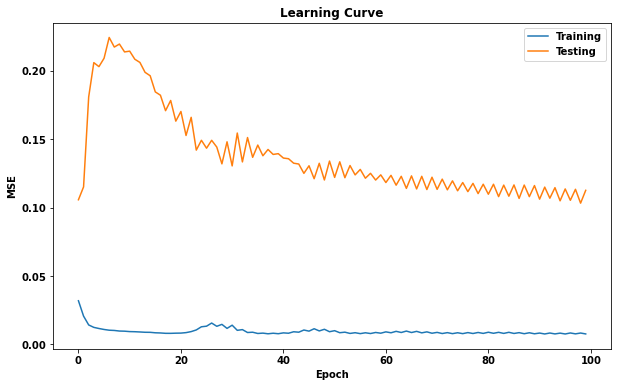

Epoch : 0 , training loss : 0.03187710095970136 , validation loss : 0.10566601157188416
Epoch : 1 , training loss : 0.02067573887931128 , validation loss : 0.11504349857568741
Epoch : 2 , training loss : 0.014211062099841094 , validation loss : 0.18080003559589386
Epoch : 3 , training loss : 0.012440143677254139 , validation loss : 0.2058461308479309
Epoch : 4 , training loss : 0.011614522102352915 , validation loss : 0.20292337238788605
Epoch : 5 , training loss : 0.010906383423592816 , validation loss : 0.20903320610523224
Epoch : 6 , training loss : 0.01037084217098726 , validation loss : 0.22423167526721954
Epoch : 7 , training loss : 0.010189109599012085 , validation loss : 0.21722210943698883
Epoch : 8 , training loss : 0.009757851944901984 , validation loss : 0.21941985189914703
Epoch : 9 , training loss : 0.009657341464908388 , validation loss : 0.2136705368757248
Epoch : 10 , training loss : 0.009354955781808323 , validation loss : 0.2142292708158493
Epoch : 11 , training loss

In [53]:
# Plot Learning Curve 
### BEGIN SOLUTION
data_module.learning_curve(num_epochs = num_epochs_covid,
                           train_loss = train_loss_covid ,
                           val_loss = val_loss_covid)

### END SOLUTION

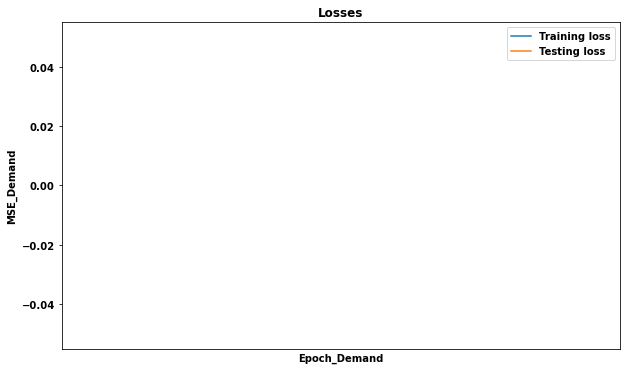

In [54]:
data_module.zoom_learning_curve(start_epoch = 280,
                                end_epoch = num_epochs_covid ,
                                training_loss = train_loss_covid,
                                validation_loss = val_loss_covid)
 

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data, determining the output forecast value and calculating the RMSE. For this exercise, use the function in `data_module` to run in each section.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

>**Instruction** : <br>
Complete each sections with the function in `data_module`

In [55]:
# Section 1 : Make predictions

### BEGIN SOLUTION
with torch.no_grad():
    y_train_prediction_covid = model_covid(train_data_dict_covid['train_data_x_feature'])
    y_test_prediction_covid = model_covid(test_data_dict_covid['test_data_x_feature'])
### END SOLUTION

In [56]:
# Assign evaluation key
### BEGIN SOLUTION
prediction_covid , output_covid = data_module.key_assign_evaluation(y_train_prediction_covid,
                                                                    y_test_prediction_covid,
                                                                    train_data_dict_covid,
                                                                    test_data_dict_covid)
### END SOLUTION

### BEGIN SOLUTION
# Squeeze the output dimension
output_data_covid = data_module.squeeze_dimension(output_covid)
### END SOLUTION

In [57]:
data_module.sanity_check(data_1 = output_data_covid,data_2 = {})

train_data_output shape : torch.Size([371, 1])
test_data_output shape : torch.Size([12, 1])


In [58]:
#Invert predictions
### BEGIN SOLUTION
scaler_covid_output = scaler_covid[list(scaler_covid)[-1]]
prediction_covid = data_module.inverse_scaler(prediction_covid,scaler_covid_output)
output_data_covid  = data_module.inverse_scaler(output_data_covid ,scaler_covid_output)
### END SOLUTION

`np.rint` is use to round our data to integer since the death cases should be in the integer form

In [59]:
prediction_covid['test_data_prediction'] = np.rint(prediction_covid['test_data_prediction'])
output_data_covid['test_data_output'] =  np.rint(output_data_covid['test_data_output']) 

In [60]:
# List the forecast value
### BEGIN SOLUTION
data_module.list_forecast_value(output_data_covid,prediction_covid) 
### END SOLUTION

Test Data			Forecast
[8.]		[7.]
[22.]		[8.]
[25.]		[8.]
[13.]		[9.]
[8.]		[8.]
[5.]		[7.]
[6.]		[8.]
[14.]		[9.]
[12.]		[9.]
[12.]		[7.]
[11.]		[7.]
[10.]		[7.]


In [61]:
# calculate root mean squared error
### BEGIN SOLUTION
trainScore_covid,testScore_covid = data_module.rmse(prediction_covid,output_data_covid)
print('Train Score: %.2f RMSE' % (trainScore_covid))
print('Test Score: %.2f RMSE' % (testScore_covid))
### END SOLUTION

Train Score: 1.68 RMSE
Test Score: 7.04 RMSE


# Step 6 : Forecast Plot

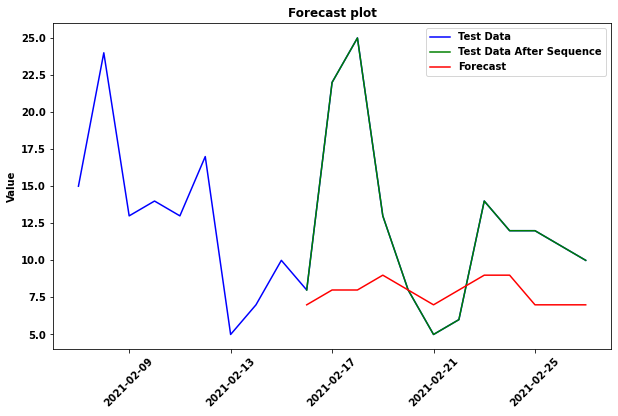

In [62]:
single_step_plot(original_test_data = test_data_covid["Deaths"],
                 sequence_test_data = output_data_covid['test_data_output'],
                 forecast_data = prediction_covid['test_data_prediction'],
                 test_time = test_time_covid,
                 window_size = window_size_covid,
                 original_plot = True,
                 multivariate = True)

## Summary
From this tutorial you should have learnt:

1. The pipeline of using LSTM perform multivariate input univariate output single-step 
2. How to import function and class from Python module `data_module.py` and `deep_learning_module.py` 
3. Some basic data exploratory technique

Congratulations, that concludes this lesson.<br>

Please save the latest `single_step_plot` and `multi_data_scaler` function to the `data_module.py`


Please proceed to other notebooks for other types of data in LSTM forecasting <br>
1. ~~*[04 - LSTM_Univariate_SingleStep]*~~  *Complete*
2. ~~*[04 - LSTM_Univariate_MultiStep.ipynb]*~~ *Complete*
3. ~~[04 - LSTM_Multivariate_Univariate_SingleStep]~~ *Complete*
4. [04 - LSTM_Multivariate_Univariate_MultiStep](./04%20-%20LSTM_Multivariate_Univariate_MultiStep.ipynb)<br>

## Reference
1. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)